In [1]:
import numpy
import h5py
import matplotlib
import os
from matplotlib import pyplot as plt
from pycbc.results import str_utils

In [2]:
# Read (log) evidence and errors, final mass and bounds from file

modes = ['220',
         '220_221',
         '220_221_222',
         '220_221_222_223',
         '220_330',
         '220_210',
         '220_330_210',
         '220_330_440',
         '220_330_440_210',
         '220_330_440_550_210'
        ]

log_evidence = {}
dlog_evidence = {}

for mode in modes:
    log_evidence[mode] = {}
    dlog_evidence[mode] = {}

    tmp_array = numpy.loadtxt('../posteriors/evidence/{}_evidence.txt'.format(mode))

    for idx in range(len(tmp_array)):
        log_evidence[mode][int(tmp_array[idx,0])] = tmp_array[idx,1]
        dlog_evidence[mode][int(tmp_array[idx,0])] = tmp_array[idx,2]


params = ['final_mass', 'f220']
median_vals = {}
error_low = {}
error_high = {}

for mode in modes:
    median_vals[mode] = {}
    error_low[mode] = {}
    error_high[mode] = {}
    for param in params:
        median_vals[mode][param] = {}
        error_low[mode][param] = {}
        error_high[mode][param] = {}

        tmp_array = numpy.loadtxt('../posteriors/median_values/{}_{}.txt'.format(mode, param))

        for idx in range(len(tmp_array)):
            median_vals[mode][param][int(tmp_array[idx,0])] = tmp_array[idx,1]
            error_low[mode][param][int(tmp_array[idx,0])] = tmp_array[idx,2]
            error_high[mode][param][int(tmp_array[idx,0])] = tmp_array[idx,3]

In [3]:
# Calculate (log) Bayes factors

log_bayes_factors = {}
log_symm_err = {}
bayes_factors = {}
bf_error_high = {}
bf_error_low = {}

for mode in log_evidence:
    log_bayes_factors[mode] = {}
    log_symm_err[mode] = {}
    bayes_factors[mode] = {}
    bf_error_high[mode] = {}
    bf_error_low[mode] = {}

    for time in log_evidence[mode]:
        if not (time in log_evidence['220'] and time in log_evidence['220_221']):
            ref_mode = '220'
        else:
            # Use max of Z(220), Z(220,221) as reference
            ref_mode = ['220', '220_221'][numpy.argmax([log_evidence['220'][time], log_evidence['220_221'][time]])]
        if mode == '220_221':
            ref_mode = '220'

        log_bayes_factors[mode][time] = log_evidence[mode][time] - log_evidence[ref_mode][time]

        log_symm_err[mode][time] = numpy.sqrt(dlog_evidence[mode][time]**2 + dlog_evidence[ref_mode][time]**2)

        bf_error_high[mode][time] = log_bayes_factors[mode][time] + log_symm_err[mode][time]
        bf_error_low[mode][time] = log_bayes_factors[mode][time] - log_symm_err[mode][time]

        bayes_factors[mode][time] = numpy.exp(log_bayes_factors[mode][time])
        bf_error_high[mode][time] = numpy.exp(bf_error_high[mode][time])
        bf_error_low[mode][time] = numpy.exp(bf_error_low[mode][time])

        bf_error_high[mode][time] = bf_error_high[mode][time] - bayes_factors[mode][time]
        bf_error_low[mode][time] = bayes_factors[mode][time] - bf_error_low[mode][time]

<ipython-input-3-50ecee886f96>:32: RuntimeWarning: overflow encountered in exp
  bayes_factors[mode][time] = numpy.exp(log_bayes_factors[mode][time])
<ipython-input-3-50ecee886f96>:33: RuntimeWarning: overflow encountered in exp
  bf_error_high[mode][time] = numpy.exp(bf_error_high[mode][time])
<ipython-input-3-50ecee886f96>:34: RuntimeWarning: overflow encountered in exp
  bf_error_low[mode][time] = numpy.exp(bf_error_low[mode][time])
<ipython-input-3-50ecee886f96>:36: RuntimeWarning: invalid value encountered in double_scalars
  bf_error_high[mode][time] = bf_error_high[mode][time] - bayes_factors[mode][time]
<ipython-input-3-50ecee886f96>:37: RuntimeWarning: invalid value encountered in double_scalars
  bf_error_low[mode][time] = bayes_factors[mode][time] - bf_error_low[mode][time]


In [4]:
# Sort Bayes factors by time
log_bayes_factors_sorted = {}
log_symm_err_sorted = {}
bayes_factors_sorted = {}
bf_error_high_sorted = {}
bf_error_low_sorted = {}

for mode in bayes_factors:
    log_bayes_factors_sorted[mode] = {}
    log_symm_err_sorted[mode] = {}
    bayes_factors_sorted[mode] = {}
    bf_error_high_sorted[mode] = {}
    bf_error_low_sorted[mode] = {}

    for time in sorted(bayes_factors[mode]):
        log_bayes_factors_sorted[mode][time] = log_bayes_factors[mode][time]
        log_symm_err_sorted[mode][time] = log_symm_err[mode][time]
        bayes_factors_sorted[mode][time] = bayes_factors[mode][time]
        bf_error_high_sorted[mode][time] = bf_error_high[mode][time]
        bf_error_low_sorted[mode][time] = bf_error_low[mode][time]

log_bayes_factors = log_bayes_factors_sorted
log_symm_err = log_symm_err_sorted
bayes_factors = bayes_factors_sorted
bf_error_high = bf_error_high_sorted
bf_error_low = bf_error_low_sorted

# Sort median values and error by time
median_vals_sorted = {}
error_low_sorted = {}
error_high_sorted = {}

for mode in median_vals:
    median_vals_sorted[mode] = {}
    error_low_sorted[mode] = {}
    error_high_sorted[mode] = {}

    for param in median_vals[mode]:
        median_vals_sorted[mode][param] = {}
        error_low_sorted[mode][param] = {}
        error_high_sorted[mode][param] = {}

        for time in sorted(median_vals[mode][param]):
            median_vals_sorted[mode][param][time] = median_vals[mode][param][time]
            error_low_sorted[mode][param][time] = error_low[mode][param][time]
            error_high_sorted[mode][param][time] = error_high[mode][param][time]

median_vals = median_vals_sorted
error_low = error_low_sorted
error_high = error_high_sorted

In [5]:
# Print Bayes factors
for mode in bayes_factors:
    print(mode)
    for time in bayes_factors[mode]:
        try:
            print(time, '${0}$'.format(str_utils.format_value(
                                        bayes_factors[mode][time],
                                        bf_error_low[mode][time],
                                        plus_error=bf_error_high[mode][time])))
        except OverflowError:
            print(time, bayes_factors[mode][time])

220
-9 $2.05^{+0.17}_{-0.16}\times 10^{-4}$
-8 $3.51^{+0.31}_{-0.28}\times 10^{-5}$
-7 $1.22^{+0.11}_{-0.10}\times 10^{-5}$
-6 $1.71^{+0.15}_{-0.13}\times 10^{-5}$
-5 $3.27^{+0.28}_{-0.26}\times 10^{-5}$
-4 $1.99^{+0.17}_{-0.16}\times 10^{-4}$
-3 $0.00145^{+0.00012}_{-0.00011}$
-2 $0.00679^{+0.00056}_{-0.00052}$
-1 $0.0177^{+0.0015}_{-0.0013}$
0 $0.210^{+0.018}_{-0.016}$
1 $0.0623^{+0.0051}_{-0.0047}$
2 $0.0928^{+0.0076}_{-0.0070}$
3 $0.0608^{+0.0049}_{-0.0045}$
4 $0.0227^{+0.0018}_{-0.0017}$
5 $0.1097^{+0.0087}_{-0.0080}$
6 $1.000^{+0.069}_{-0.065}$
7 $1.000^{+0.070}_{-0.065}$
8 $1.000^{+0.076}_{-0.071}$
9 $1.000^{+0.074}_{-0.069}$
10 $1.000^{+0.075}_{-0.069}$
11 $1.000^{+0.067}_{-0.062}$
12 $1.000^{+0.069}_{-0.065}$
13 $1.000^{+0.073}_{-0.068}$
14 $1.000^{+0.070}_{-0.066}$
15 $1.000^{+0.076}_{-0.070}$
16 $1.000^{+0.072}_{-0.067}$
17 $1.000^{+0.066}_{-0.062}$
18 $0.726^{+0.051}_{-0.047}$
19 $0.945^{+0.065}_{-0.061}$
20 $1.000^{+0.068}_{-0.063}$
21 $1.000^{+0.069}_{-0.065}$
22 $1.000^{

/Users/cdcapano/miniconda3/envs/pycbc-master/lib/python3.9/site-packages/PyCBC-0.0a8623-py3.9-macosx-11.1-arm64.egg/pycbc/results/str_utils.py:194: RuntimeWarning: invalid value encountered in double_scalars
  value = value * 10**(-conversion_factor)


# Plot Figure 2

In [6]:
# Times of maximum Bayes factor in ms relative to reference time
max330 = 6
max221 = -7

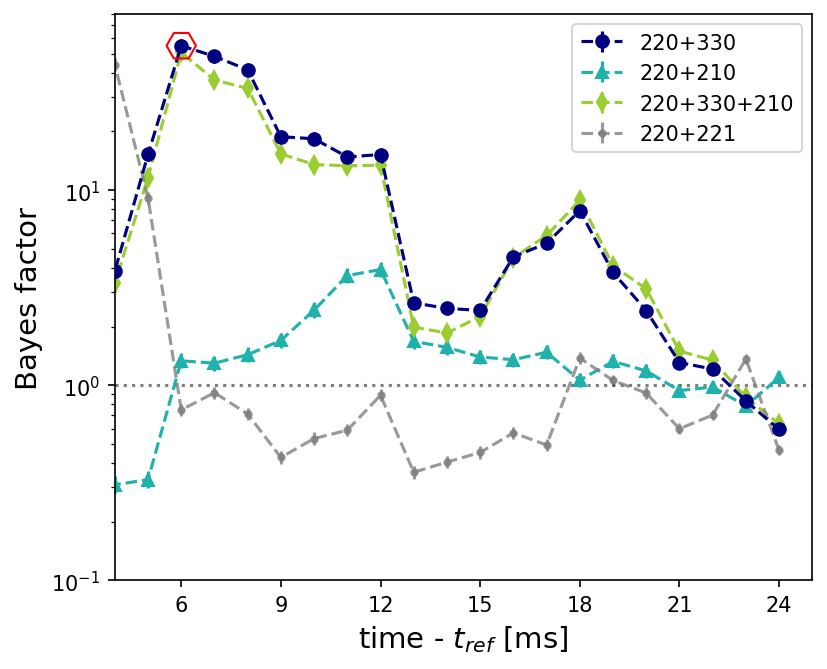

In [7]:
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')

tmp_mode = '220_330'
ax.errorbar([t for t in bayes_factors[tmp_mode]],
           [bayes_factors[tmp_mode][t] for t in bayes_factors[tmp_mode]],
           yerr=[[bf_error_low[tmp_mode][t] for t in bf_error_low[tmp_mode]],
                 [bf_error_high[tmp_mode][t] for t in bf_error_high[tmp_mode]]],
           label=tmp_mode.replace('_', '+'), marker='o', ls='--', c='navy', zorder=3)

ax.scatter(max330,
              bayes_factors['220_330'][max330],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=4)

ax.scatter(max221,
              bayes_factors['220_221'][max221],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=4)

if True:
    tmp_mode = '220_210'
    ax.errorbar([t for t in bayes_factors[tmp_mode]],
           [bayes_factors[tmp_mode][t] for t in bayes_factors[tmp_mode]],
           yerr=[[bf_error_low[tmp_mode][t] for t in bf_error_low[tmp_mode]],
                 [bf_error_high[tmp_mode][t] for t in bf_error_high[tmp_mode]]],
           label=tmp_mode.replace('_', '+'), marker='^', ls='--', c='lightseagreen')

tmp_mode = '220_330_210'
ax.errorbar([t for t in bayes_factors[tmp_mode]],
           [bayes_factors[tmp_mode][t] for t in bayes_factors[tmp_mode]],
           yerr=[[bf_error_low[tmp_mode][t] for t in bf_error_low[tmp_mode]],
                 [bf_error_high[tmp_mode][t] for t in bf_error_high[tmp_mode]]],
           label=tmp_mode.replace('_', '+'), marker='d', ls='--', c='yellowgreen')

if False:
    tmp_mode = '220_330_440_210'
    ax.errorbar([t for t in bayes_factors[tmp_mode]],
           [bayes_factors[tmp_mode][t] for t in bayes_factors[tmp_mode]],
           yerr=[[bf_error_low[tmp_mode][t] for t in bf_error_low[tmp_mode]],
                 [bf_error_high[tmp_mode][t] for t in bf_error_high[tmp_mode]]],
           label=tmp_mode.replace('_', '+'), marker='s', ls='--', c='yellowgreen')

tmp_mode = '220_221'
ax.errorbar([t for t in bayes_factors[tmp_mode]],
           [bayes_factors[tmp_mode][t] for t in bayes_factors[tmp_mode]],
           yerr=[[bf_error_low[tmp_mode][t] for t in bf_error_low[tmp_mode]],
                 [bf_error_high[tmp_mode][t] for t in bf_error_high[tmp_mode]]],
           label=tmp_mode.replace('_', '+'), marker='.',
           ls='--', alpha=0.8, c='gray')

ax.axhline(1, color='k', alpha=0.5, ls=':')

ax.set_ylabel("Bayes factor", fontsize=14)
ax.set_xlabel("time - $t_{\t{ref}}$ [ms]", fontsize=14)
ax.legend(loc='best') #loc=(0.505, 0.35))
ax.set_xticks([-9,-6,-3,0,3,6,9,12,15,18,21,24])
ax.set_yscale("log")
ax.set_xlim(4,25)
ax.set_ylim(0.1,80)

fig.set_dpi(150)
fig.savefig("../figures/Figure2.png", dpi=300, bbox_inches='tight')

# Plot Figure S.4

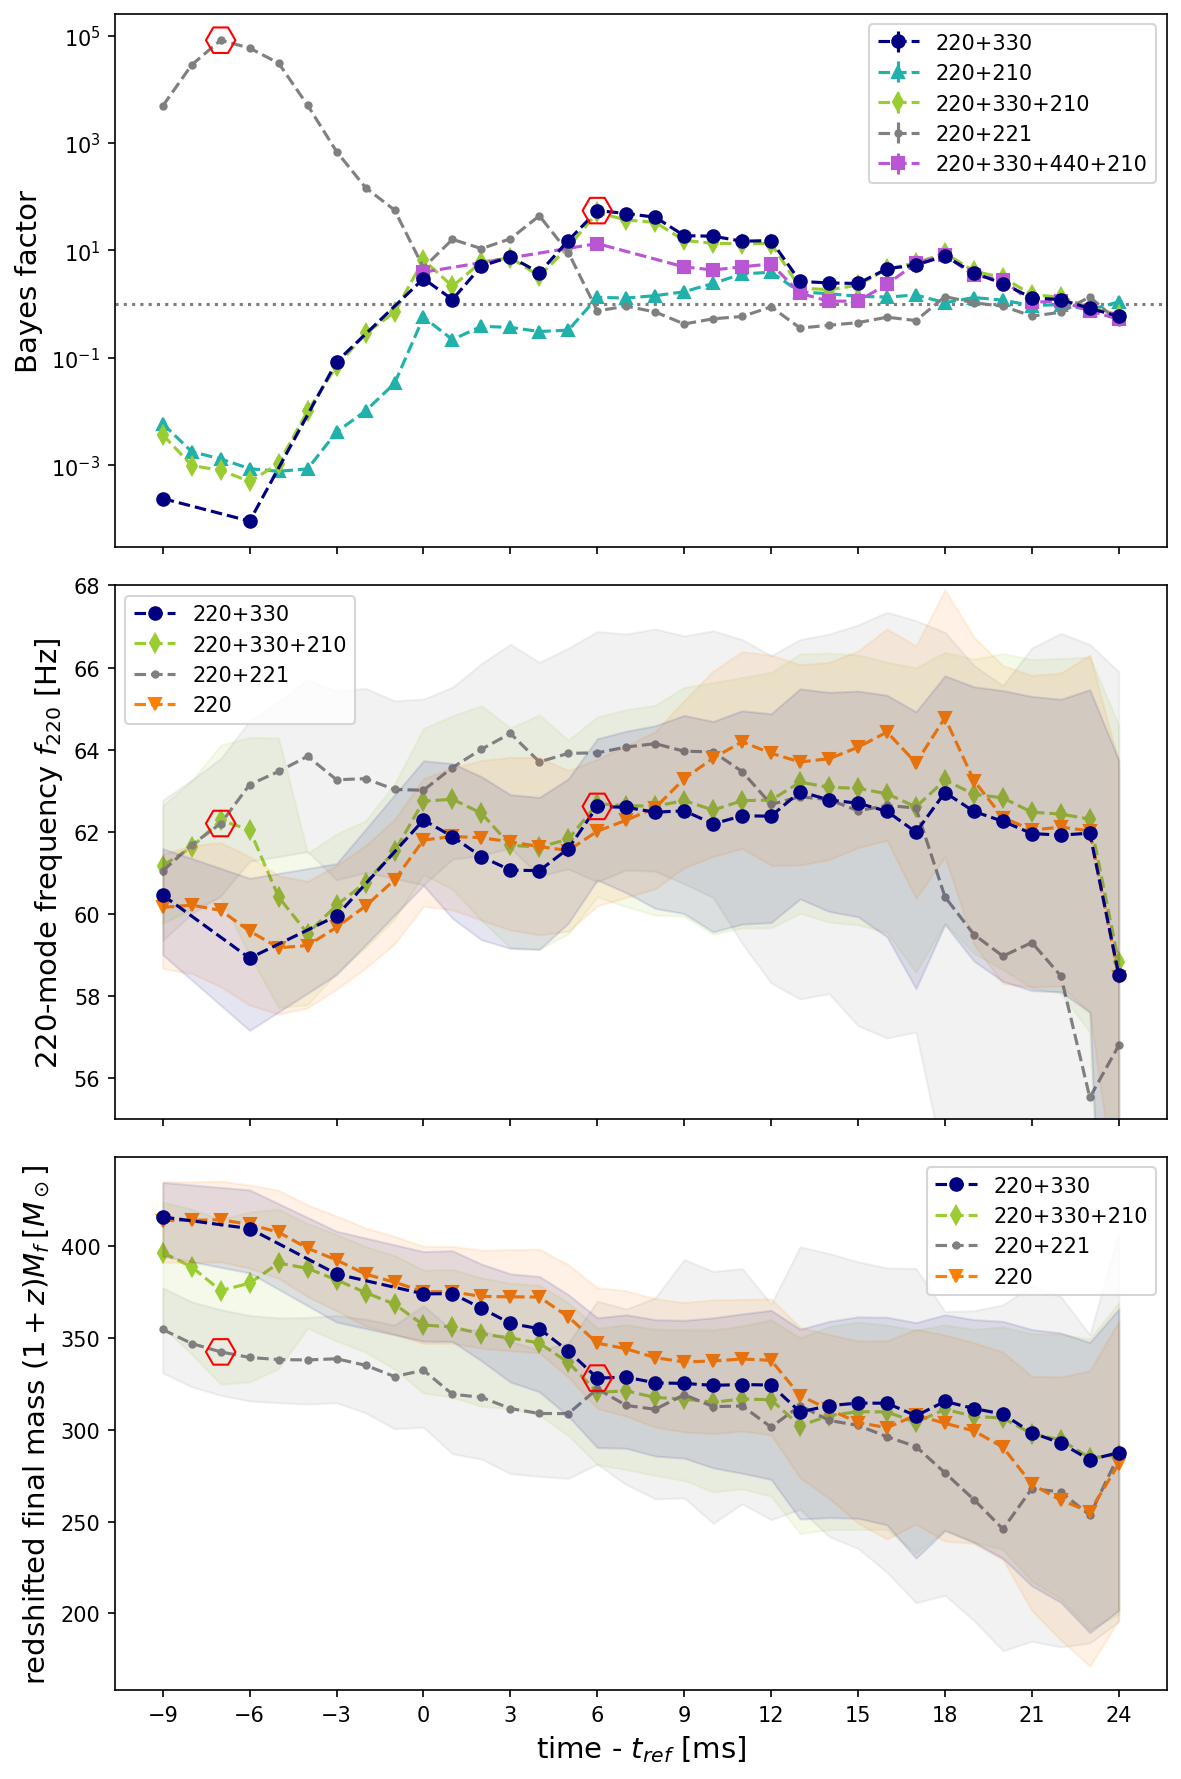

In [11]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,12), facecolor='w')

# Panel 1 #########################################
modes = ['220_330',
         '220_210',
         '220_330_210',
         '220_221',
         '220_330_440_210'
        ]
colours = ['navy', 'lightseagreen', 'yellowgreen', 'gray', 'mediumorchid']
markers = ['o', '^', 'd', '.', 's']

for count, tmp_mode in enumerate(modes):
    zord = 3
    if tmp_mode == '220_330':
        zord = 4
    ax[0].errorbar([t for t in bayes_factors[tmp_mode]],
                   [bayes_factors[tmp_mode][t] for t in bayes_factors[tmp_mode]],
                   yerr=[[bf_error_low[tmp_mode][t] for t in bf_error_low[tmp_mode]],
                         [bf_error_high[tmp_mode][t] for t in bf_error_high[tmp_mode]]],
                   label=tmp_mode.replace('_','+'),
                   marker=markers[count],
                   ls='--',
                   c=colours[count],
                   zorder=zord)


ax[0].scatter(max330,
              bayes_factors['220_330'][max330],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=5)

ax[0].scatter(max221,
              bayes_factors['220_221'][max221],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=5)

ax[0].axhline(1, color='k', alpha=0.5, ls=':')

ax[0]

ax[0].set_ylabel("Bayes factor", fontsize=14)
ax[0].legend(loc='best') #loc=(0.505, 0.35))
ax[0].set_xticks([-9,-6,-3,0,3,6,9,12,15,18,21,24])
ax[0].set_yscale("log")
#ax[0].set_xlim(4,25)
#ax[0].set_ylim(0.1,80)


# Panel 2 #########################################
modes = ['220_330',
         '220_330_210',
         '220_221',
         '220',
         #'220_330_440_210'
        ]

colours = ['navy', 'yellowgreen', 'gray', '#ff7f00']#,'mediumorchid']
markers = ['o', 'd', '.', 'v']#, 's']
param = 'f220'

for count, mode in enumerate(modes):
    zord = 2
    if mode == '220_330':
        zord = 3

    ax[1].fill_between([t for t in median_vals[mode][param]],
                       [median_vals[mode][param][t] - error_low[mode][param][t] for t in median_vals[mode][param]],
                       [median_vals[mode][param][t] + error_high[mode][param][t] for t in median_vals[mode][param]],
                       alpha=0.1,
                       color=colours[count],
                       zorder=zord)

    ax[1].plot([t for t in median_vals[mode][param]],
               [median_vals[mode][param][t] for t in median_vals[mode][param]],
               label=mode.replace('_','+'),
               color=colours[count],
               marker=markers[count],
               ls='--',
               zorder=zord)

ax[1].scatter(max221,
              median_vals['220_221'][param][max221],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=4)

ax[1].scatter(max330,
              median_vals['220_330'][param][max330],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=4)

ax[1].set_ylabel("220-mode frequency $f_{220}$ [Hz]", fontsize=14)
ax[1].set_ylim(55,68)
ax[1].legend()


# Panel 3 #########################################
#modes = ['220_330',
#         '220_330_210',
#         '220_221',
#         '220'
#        ]

#colours = ['navy', 'yellowgreen', 'gray', '#ff7f00']
#markers = ['o', 'd', '.', 'v']
param = 'final_mass'

for count, mode in enumerate(modes):
    zord = 2
    if mode == '220_330':
        zord = 3

    ax[2].fill_between([t for t in median_vals[mode][param]],
                       [median_vals[mode][param][t] - error_low[mode][param][t] for t in median_vals[mode][param]],
                       [median_vals[mode][param][t] + error_high[mode][param][t] for t in median_vals[mode][param]],
                       alpha=0.1,
                       color=colours[count],
                       zorder=zord)

    ax[2].plot([t for t in median_vals[mode][param]],
               [median_vals[mode][param][t] for t in median_vals[mode][param]],
               label=mode.replace('_','+'),
               color=colours[count],
               marker=markers[count],
               ls='--',
               zorder=zord)

ax[2].scatter(max221,
              median_vals['220_221'][param][max221],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=4)

ax[2].scatter(max330,
              median_vals['220_330'][param][max330],
              marker='H',
              color='red',
              facecolor='none',
              s=200,
              zorder=4)

ax[2].set_xlabel("time - $t_{\t{ref}}$ [ms]", fontsize=14)
ax[2].set_ylabel("redshifted final mass $(1+z)M_f \: [M_\odot]$", fontsize=14)
ax[2].legend()

fig.tight_layout()
fig.set_dpi(150)
fig.savefig("../figures/FigureS4.png", dpi=300, bbox_inches='tight')